<a href="https://colab.research.google.com/github/GerardAlba/UdAAnaliticaFinancera/blob/main/UdAForecasting_Inflation_with_ARIMA_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Nowcasting per a la predicció de la Inflació

##  Importem llibreries i dataset


In [74]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [75]:
print(tf.__version__)

2.17.0


In [76]:
from google.colab import drive
drive.mount('/content/drive')
monthly_raw = pd.read_csv('/content/macro_monthly.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
# = pd.read_csv('https://github.com/GerardAlba/UdAAnaliticaFinancera/blob/main/macro_monthly.csv',parse_dates=True)
monthly_raw.shape

(490, 12)

Preparem dades: eliminem NaNs.

In [78]:
monthly_raw.dropna(inplace=True)
monthly_raw.head(5)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


In [79]:
monthly_raw.dtypes

monthly_raw.DATE = pd.to_datetime(monthly_raw.DATE)

,0
DATE,object
unrate,float64
psr,float64
m2,float64
dspic,float64
pce,float64
reer,float64
ir,float64
ffer,float64
tcs,float64


In [80]:
monthly_raw['DATE'].nunique()

334

Creem una còpia de les dades mensuals

In [81]:
monthly_df = monthly_raw.copy()

### Indicadors Macroeconòmics i dades Inflació

Generem les variacions de preus -Inflació- mensual i anual

array([[<Axes: title={'center': 'Unemployment Rate'}>,
        <Axes: title={'center': 'Personal Saving Rate'}>,
        <Axes: title={'center': 'M2'}>],
       [<Axes: title={'center': 'Disposable Income'}>,
        <Axes: title={'center': 'Personal Consumption Expenditure'}>,
        <Axes: title={'center': 'Real Effective Exchange Rate'}>],
       [<Axes: title={'center': '10Y Treasury Yield'}>,
        <Axes: title={'center': 'Fed Rate'}>,
        <Axes: title={'center': 'Construction Spending'}>],
       [<Axes: title={'center': 'Industrial Production Index'}>,
        <Axes: title={'center': 'Core CPI'}>,
        <Axes: title={'center': 'Core CPI % Change MoM'}>]], dtype=object)

Text(0.5, 0.98, 'Indicadors Macroeconòmics EE.UU')

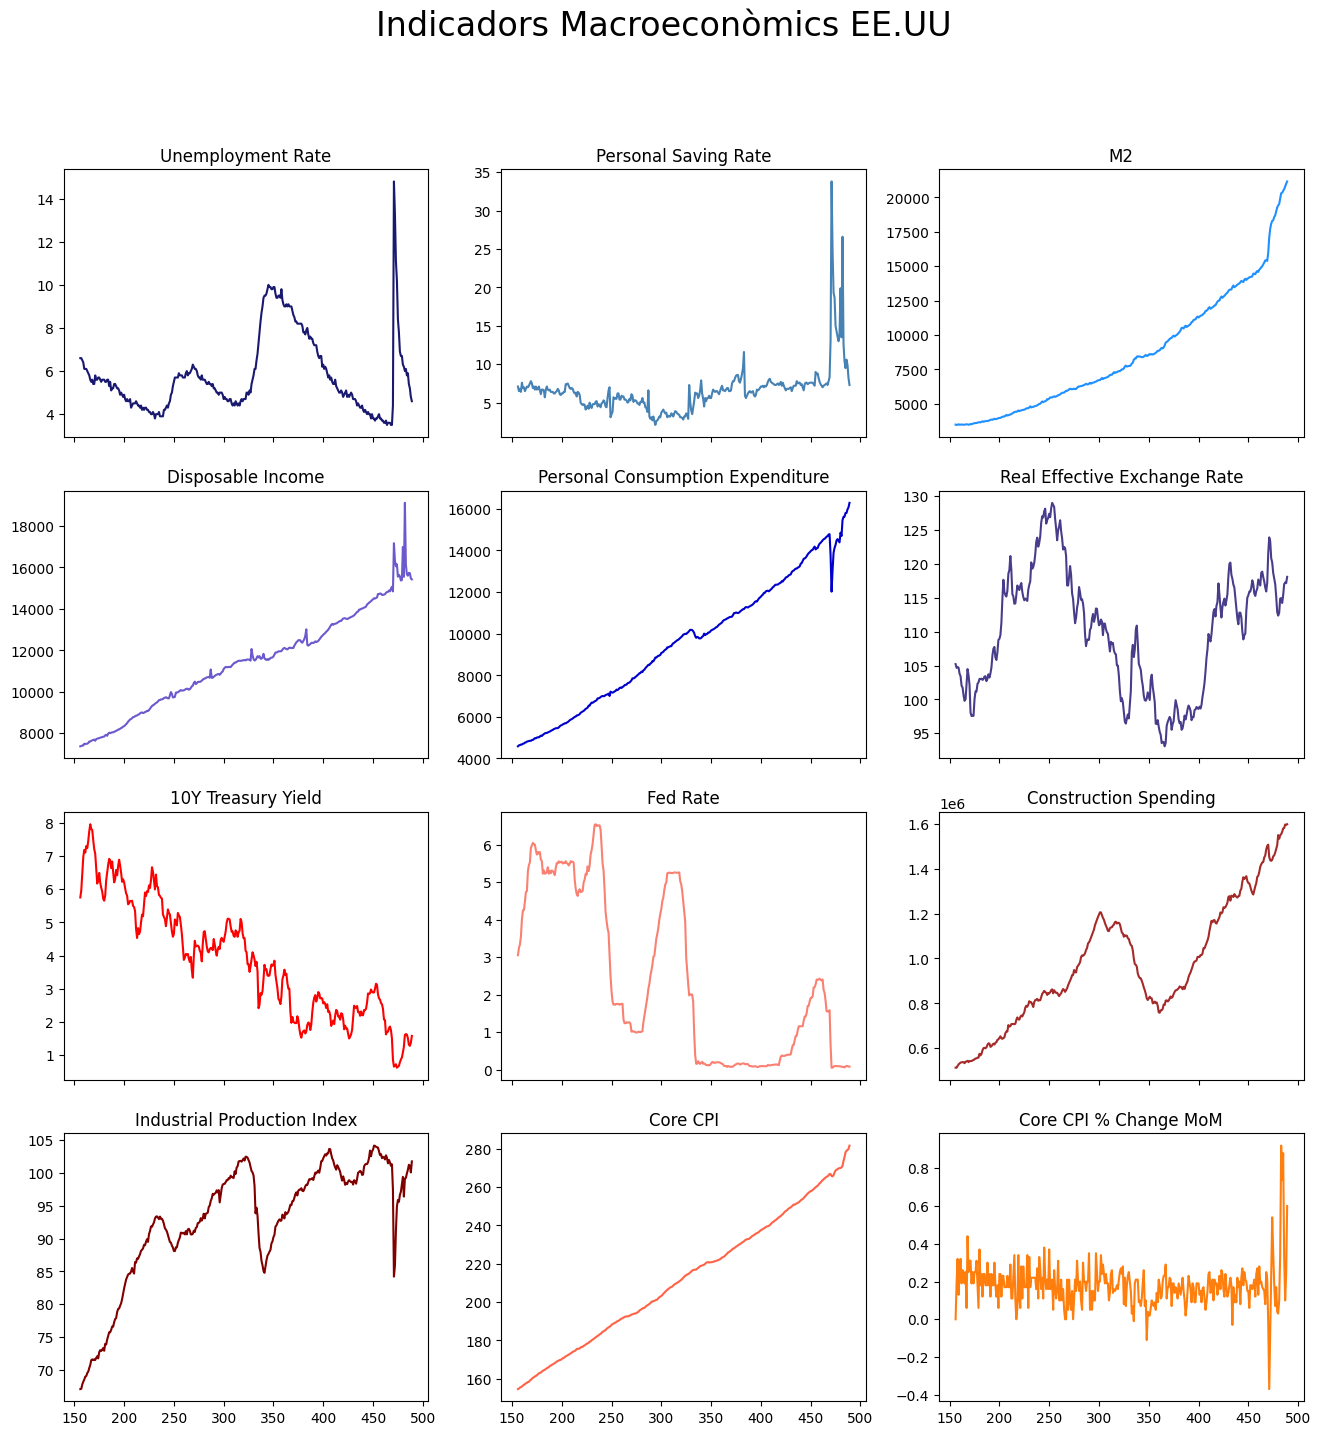

In [82]:
monthly_df['cpi_pct_mom'] = round((monthly_df['ccpi'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['ccpi'].pct_change(12).fillna(0))*100,2)

monthly_df.iloc[:, 1:13].plot(kind ='line',
            subplots = True,
            figsize = (16,16),
            title = ['Unemployment Rate', 'Personal Saving Rate','M2','Disposable Income','Personal Consumption Expenditure','Real Effective Exchange Rate',
                     '10Y Treasury Yield','Fed Rate','Construction Spending','Industrial Production Index','Core CPI','Core CPI % Change MoM'],
            legend = False,
            layout = (4,3),
            sharex = True,
            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue','darkslateblue','red','salmon','brown','maroon','tomato'])

plt.suptitle('Indicadors Macroeconòmics EE.UU', fontsize = 24)

### Tendència de la inflació (CPI)


In [83]:
monthly_df['year'] = monthly_df['DATE'].apply(lambda x: x.year)
monthly_df['quarter'] = monthly_df['DATE'].apply(lambda x: x.quarter)
monthly_df['month'] = monthly_df['DATE'].apply(lambda x: x.month)

In [84]:
fig = px.box(monthly_df[12:], x="month", y="cpi_pct_yoy", points = "all", template = "presentation",)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',))

fig = px.box(monthly_df[12:], x="quarter", y="cpi_pct_yoy", points = "all", template = "presentation")

#Codi original modificat per plotlib: cal paràmetre render Colabb
fig.show(renderer="colab")

La inflació anual és més elevada durant els primers trimestres dels anys. En els darrers mesos de l'any, fins i tot alguns outliers amb variació inflació baixa. Podem veure la volatilitat o dispersió de cada trimestre en el gràfic següent.


In [85]:
fig = px.bar(
    data_frame=monthly_df.groupby(['month']).std().reset_index(),
    x="month",
    y="cpi_pct_yoy", text="cpi_pct_yoy"
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)
fig.show(renderer="colab")

fig = px.bar(
    data_frame=monthly_df.groupby(['quarter']).std().reset_index(),
    x="quarter",
    y="cpi_pct_yoy", text="cpi_pct_yoy").update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)
fig.show(renderer="colab")

## Predicció de la Inflació

In [86]:
monthly_raw.shape
monthly_raw.head(5)

(334, 12)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


L'índex del dataframe usat és la data DATE

In [87]:
df_cpi = monthly_raw.set_index('DATE')

## Model ARIMA
Veure document teoria curs UdA

### Descomposició de la Sèrie Temporal
Tendència, Estacional i Residual

<Axes: xlabel='DATE'>

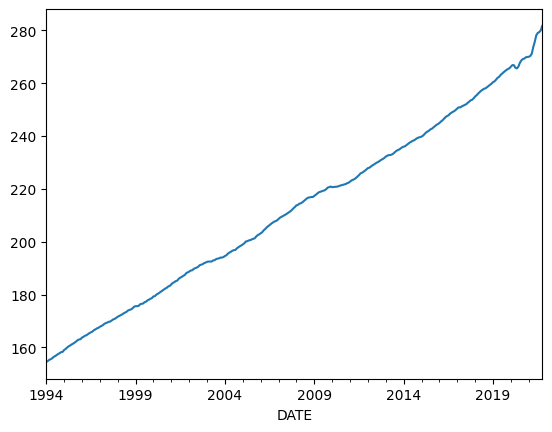

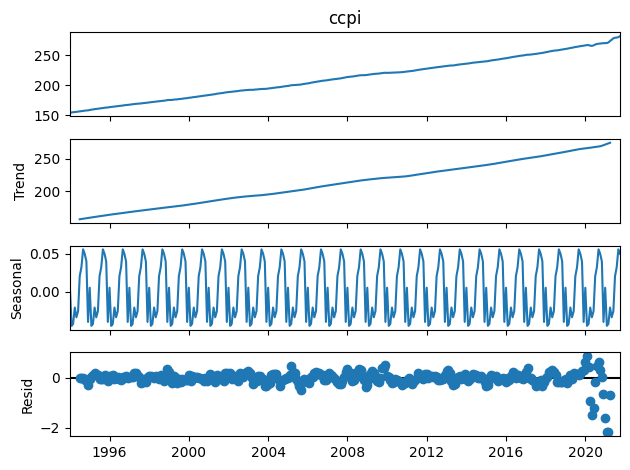

In [88]:
df_cpi['ccpi'].plot()
fig = seasonal_decompose(df_cpi['ccpi'], model='additive').plot()

Tendència positiva i sèrie no estacionària.
Haurem d'aplicar més endavant un procés per convertir en estacionària.

### Dataset Train i Test
Test són els darrers 12 mesos

Training dataset: 322, Test dataset: 12


<Axes: xlabel='DATE'>

<Axes: xlabel='DATE'>

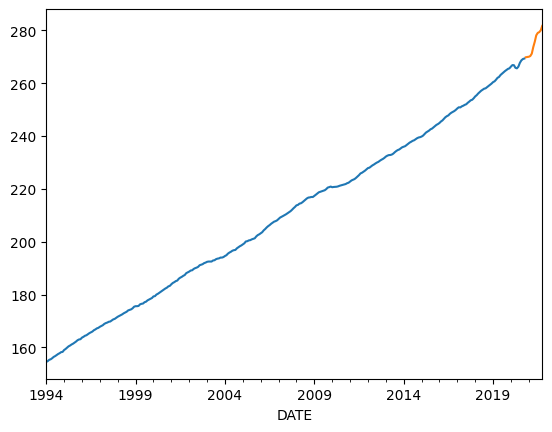

In [89]:
split_point = len(df_cpi) - 12
train, test = df_cpi[0:split_point], df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['ccpi'].plot()
test['ccpi'].plot()

### Estacionàries
Convertim a dades estacionàries. Usem funció diff() i Dickey-Fuller test.

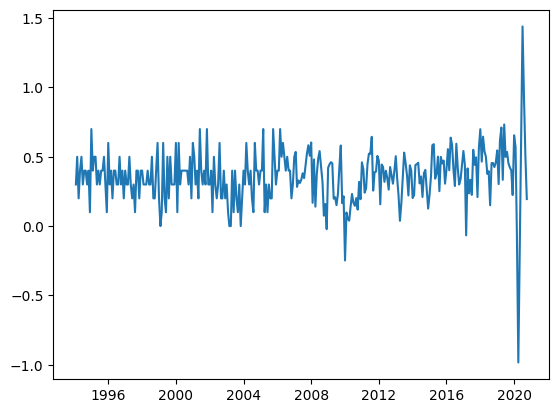

In [90]:
diff = train['ccpi'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

### Augmented Dickey–Fuller test
With the small p-value, a 1 differencing is enough to remove unit root and make the series stationary.

In [91]:
def adf_test(df):
    result = adfuller(df.values)
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

adf_test(diff)

Series is stationary


### Plot ACF and PACF
Now, we need to find the optimal p and q using acf and pacf plot. Where p is the number of lags and q is the order of the MA term. <br><br>
Finding the order of Auto Regressive Term (p)
- PACF lag 1 is significant

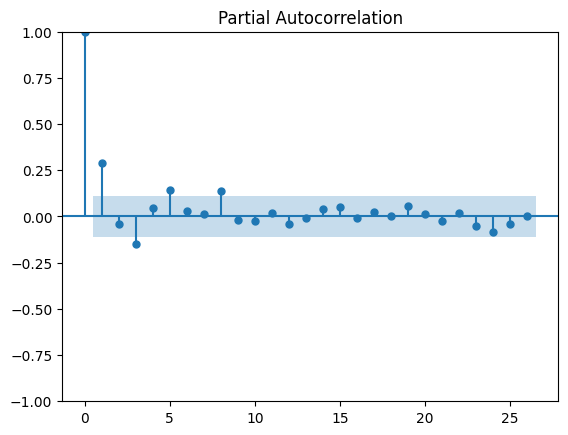

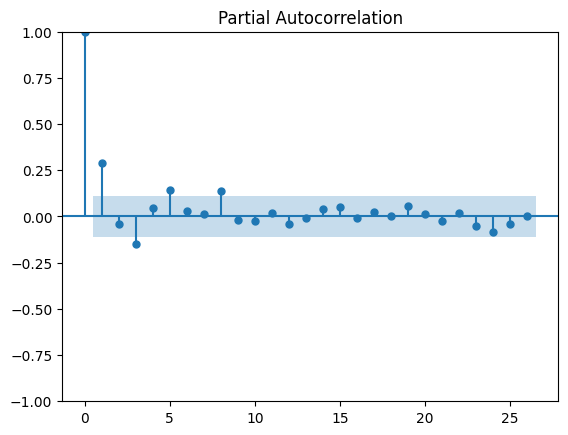

In [92]:
plot_pacf(diff.values)

Finding the order of Moving Average Term (q)<br>
- q = 1 and 2 is significant, try conservative take of q = 1.

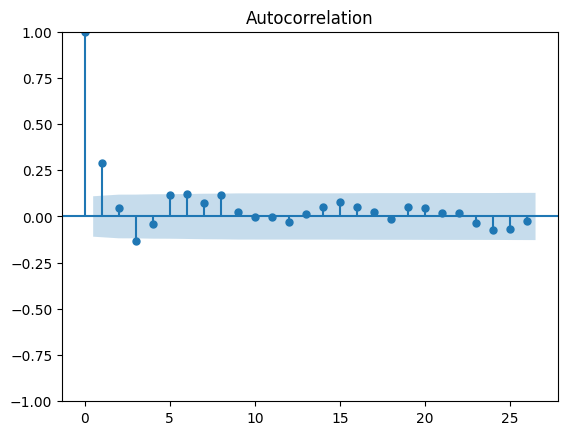

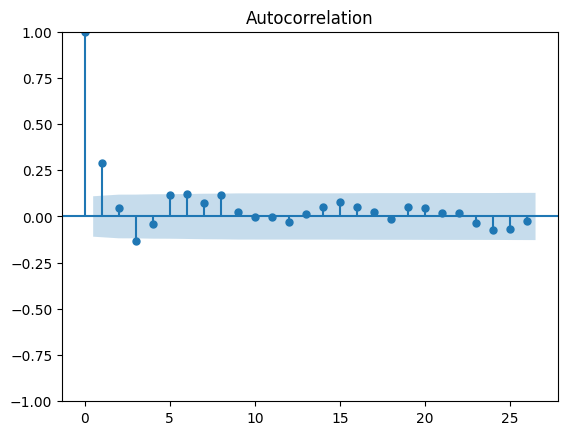

In [93]:
plot_acf(diff.values)

### Construcció del model
Modelarem ln(CPI), ja que s'observa creixement exponencial. Els paràmetres vistos ens porten a usar ARIMA (1,1,1)

In [94]:
arima_model = ARIMA(np.log(train['ccpi']), order = (1,1,1))

arima_fit = arima_model.fit()
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ccpi   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1780.484
Date:                Fri, 30 Aug 2024   AIC                          -3554.968
Time:                        06:02:06   BIC                          -3543.654
Sample:                    01-01-1994   HQIC                         -3550.450
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.016     59.833      0.000       0.937       1.000
ma.L1         -0.5010      0.043    -11.606      0.000      -0.586      -0.416
sigma2      8.851e-07   4.25e-08     20.833      0.000    8.02e-07    9.68e-07
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):               180.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.27
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predicció pel període test
Forecast out-of-sample

Inflació projectada (CPI) YoY:  1.39


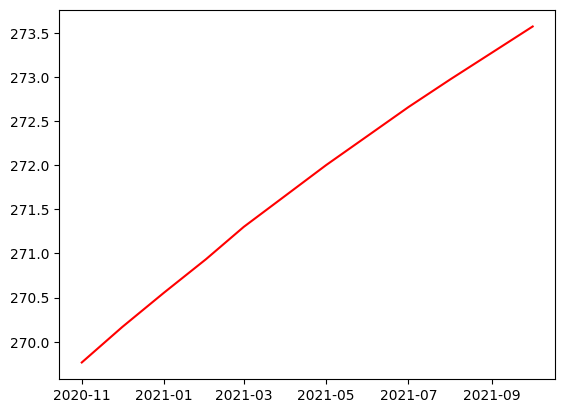

In [95]:
forecast = arima_fit.forecast(steps=12)
forecast = np.exp(forecast)

plt.plot(forecast, color = 'red')

pct_chg = ((forecast[-1] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('Inflació projectada (CPI) YoY: ' , round(pct_chg,2))

### Evaluem el model ARIMA
Usem error quadràtic i comparem predicció amb observat (test)
El model sobreestima la inflació, en mitjana, en un 0,25% aprox

In [96]:
mse = mean_squared_error(test['ccpi'].values, forecast[:12])
print('MSE: ', mse)
model_error = test['ccpi'] - forecast
print('Error mitja del model: ', model_error.mean())

MSE:  20.43574094104357
Error mitja del model:  3.1464952666371317


### 1-Step Forecast for November 2021

In [97]:
arima_model = ARIMA(np.log(test['ccpi']), order = (1,1,1),freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)
forecast = np.exp(forecast)

print('Inflació predita pel model ARIMA', round(forecast[0],2))

Inflació predita pel model ARIMA 283.19


En general, observem com ARIMA no s'ajusta prou bé. Veiem a continuació LSTM amb una variable (la pròpia *y*), i també amb vàries característiques o variables (les macro del dataset)



## Univariate Time Series Forecasting with LSTM
<a id = "ulstm"></a>
Long Short-Term Memory (LSTM) Recurrent Neural Network are popular in making predictions based on time series data, due to the lags of unknown duration. LSTM addresses that issue of vanishing gradient with multiple switch gates to remember longer time steps. Hence the past inputs to the model leaves a footprint. With LSTMs, there is no need to keep a finite number of states beforehand as required in the Hhidden Markov model. Common limitations (risk) of LSTM is that it is easy to overfit and hard to train in a sense that it takes alot of resources (computing power) to train these models fast, requiring memory-bandwidth-bound computation.

As the problem requires foreccasting the Core CPI value of the January 2021, we can use LSTM to predict a one-step out forecast, using 12 input time steps.

The LSTM architecture will be a simple, vanilla LSTM with one hidden layer with default activation tanh.

**References**:<br>
[The fall of RNN / LSTM](https://towardsdatascience.com/the-fall-of-rnn-lstm-2d1594c74ce0) by Eugenio Culurciello <br>
[Essentials of Deep Learning : Introduction to Long Short Term Memory](https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

### Scaling and Data Preparation
- Scaling with Min-Max Normalization
- Split the univariate sequence into samples with 12 steps in 1 step out

**References**<br>
The split sequence code is based on Machine Learning Mastery's code, available [here](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/).

In [98]:
scaler = MinMaxScaler(feature_range=(0, 1))
#Modifiquem codi original, columna ccpi del dataframe cal convertir en array numpy
ccpi=df_cpi['ccpi'].to_numpy()
dataset = scaler.fit_transform(ccpi.reshape(-1,1))

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


As above, we create a data structure with 12 timesteps and 1 output.

In [99]:
n_steps_in = 12

train, test = dataset[0:310], dataset[310:len(dataset),:]

trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

### Training the Model

Build vanilla model with a single layer, no dropout regularization and no Early Stopping. The number of neurons that will be used is 100, for high dimensionality (so the model can capture the trends). Most parameters are chosen through a fine-tuning and trial-and-error approach.

The number of layer, 1 is chosen because of the complexity of the problem. <br>No dropout regularization due to the simple complexity nature (there is 1 layer only, and adding dropout would cause important information to be lost) of the built neural network and dataset size. Dropout regularization at optimal levels 0.1/0.2 for LSTM were trialed and significantly decreased the performance of prediction on the test set. Dropout erase important context information, especially in this problem with limited timesteps and 1 layer. Furthermore, train loss and validation loss are carefully monitored for any overfitting.<br>
Similarly, a small learning rate of 0.001 is used due to size of the neural network and small data size.

The batch size is set as 100 epochs. Batch size fine-tuning is done based on the observation of model's peformance.


<function matplotlib.pyplot.show(close=None, block=None)>

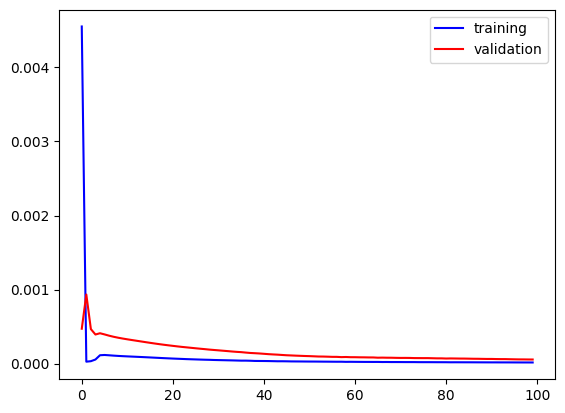

In [100]:
n_features = trainX.shape[2]

uni_model = Sequential()

# Afegim capa oculta LSTM
uni_model.add(LSTM(64, input_shape=(trainX.shape[1], n_features)))

# Afegim una sola capa de 100 nodes
uni_model.add(Dense(1))

uni_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error', metrics=['mean_absolute_error'])

fit = uni_model.fit(trainX,
          trainY, validation_data = (testX, testY),
          epochs = 100, batch_size=1,
          verbose = 0)


# Validem overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show

We can see a slight overfit.

**Note**: The validation loss shows significant spike and fluctuations due to the small batch_size passed in.

### Predictions on Test Set
- Make predictions on both the train set and test set
- Inverse transform from normalized back to the original value.

In [101]:
trainPredict = uni_model.predict(trainX)
testPredict = uni_model.predict(testX)

Ytrain_hat = scaler.inverse_transform(trainPredict)
Ytrain_actual = scaler.inverse_transform(trainY)
Ytest_hat = scaler.inverse_transform(testPredict)
Ytest_actual = scaler.inverse_transform(testY)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


### Evaluating the univariate LSTM

Similar to the ARIMA, we will use MSE and Mean Model Error to evaluate the model's forecasting power.

In [102]:
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score: %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual, Ytest_hat[:,0])
print('Test Score: %.2f MSE' % (testScore))

model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error: ', model_error.mean())

Train Score: 0.18 MSE
Test Score: 0.90 MSE
Mean Model Error:  -0.3005866699218795


This model showed significant improvement compared to ARIMA model with MSE of 1.70 and Mean Model Error of 0.78 which indicates the model gives a slight underestimation. Based on the MSE, the model has an average error of sqrt(1.70) = 1.30.



Now, we can plot the actual 2020 Core CPI against the forecasted 2020 Core CPI.

<Axes: title={'center': 'Real'}, xlabel='DATE'>

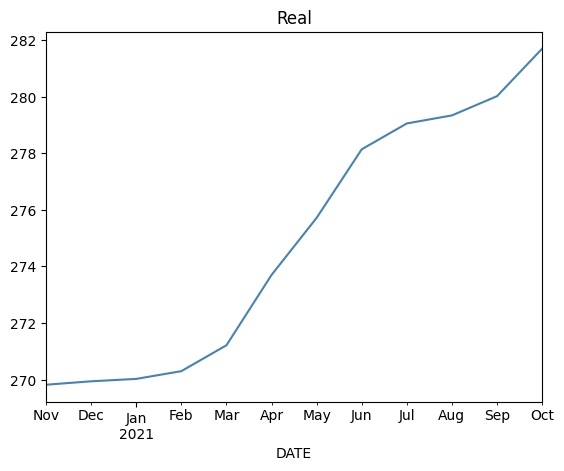

<Axes: title={'center': 'Predicció'}>

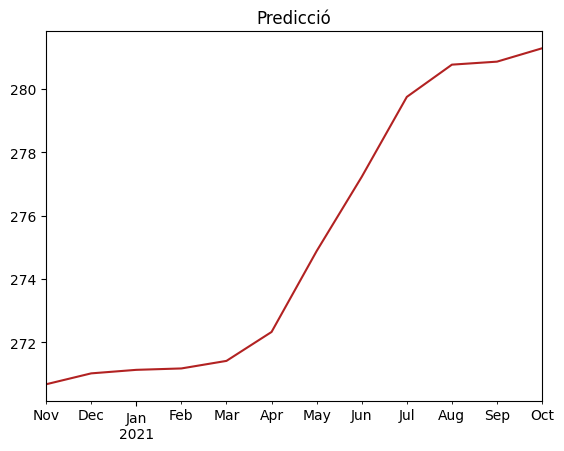

In [103]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Real', legend = False)
plt.show()

predicted = pd.DataFrame(Ytest_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Predicció', legend = False)
plt.show()

From the above line chart, we can see that the univariate LSTM is able to "approximate" the shape of the Core CPI (though lagging) and underestimates the value.

### Forecast for November 2021

We input the last 12 observations (12 steps in) into the model for it to forecast 1 step out which will be the Core CPI value for the month of November 2021.

Then, calculate the year-on-year percentage change manually.

In [52]:
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = uni_model.predict(x_input)

forecast = scaler.inverse_transform(forecast_normalized)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast[0][0])

pct_chg = ((forecast[0][0] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The Core CPI value for the month Nov 2021 predicted by LSTM is  283.12643
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.93


## Model LSTM multivariant per a la predicció CPI
### Preparació de les dades
- Característiques principalsusant Granger Causality Test
- Normalització Min-Max



#### Selecció de característiques
Usem test de Granger Causality per seleccionar característiques. Les dades cal que siguin estacionàries pel test, fem transformacions prèvies (ADF test per verificar estacionàries)

In [53]:
monthly_df_stationary = df_cpi.diff().dropna()
monthly_df_stationary = monthly_df_stationary.rename_axis('indicator', axis=1)
fig = px.line(monthly_df_stationary.iloc[:,0:10], facet_col="indicator", facet_col_wrap=1)
fig.update_yaxes(visible=False)

In [54]:
for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])

monthly_df_stationary[['m2']] = monthly_df_stationary[['m2']].diff().dropna()
monthly_df_stationary[['tcs']] = monthly_df_stationary[['tcs']].diff().dropna()
monthly_df_stationary[['ccpi']] = monthly_df_stationary[['ccpi']].diff().dropna()

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is not stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is not stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is not stationary


Apliquem diferències per reduïr no-estacionarietat. Però M2, TCS i CCPI continuen sent no-estacionàries. Tornem a fer diferències.

In [55]:
# Drop any NaNs first
monthly_df_stationary = monthly_df_stationary.dropna()

for indi in monthly_df_stationary:
    print('ADF Test: ', indi)
    adf_test(monthly_df_stationary[[indi]])

ADF Test:  unrate
Series is stationary
ADF Test:  psr
Series is stationary
ADF Test:  m2
Series is stationary
ADF Test:  dspic
Series is stationary
ADF Test:  pce
Series is stationary
ADF Test:  reer
Series is stationary
ADF Test:  ir
Series is stationary
ADF Test:  ffer
Series is stationary
ADF Test:  tcs
Series is stationary
ADF Test:  indpro
Series is stationary
ADF Test:  ccpi
Series is stationary


M2, TCS i CCPI ja són ara estacionàries.
Apliquem test Grangers Causality Test per investigar causalitat entre les característiques i la inflació CPI.

Codi es pot obtenir de: [stackoverflow](https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with).

In [56]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(monthly_df_stationary, variables = monthly_df_stationary.columns)

,unrate_x,psr_x,m2_x,dspic_x,pce_x,reer_x,ir_x,ffer_x,tcs_x,indpro_x,ccpi_x
unrate_y,1.0000,0.0018,0.0000,0.0677,0.0000,0.0011,0.0015,0.0000,0.1951,0.0000,0.0022
psr_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0277,0.0200,0.0000,0.0001,0.0000,0.0000
m2_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0163,0.0468,0.0000,0.0275,0.0000,0.0000
dspic_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.1799,0.1497,0.0027,0.0000,0.0000,0.0000
pce_y,0.0000,0.0002,0.0000,0.0000,1.0000,0.0059,0.0218,0.0000,0.0103,0.0000,0.0005
reer_y,0.2565,0.3279,0.0335,0.2618,0.2323,1.0000,0.0601,0.5281,0.5866,0.1191,0.0266
ir_y,0.6902,0.5921,0.5635,0.5920,0.6647,0.0733,1.0000,0.3952,0.3772,0.1995,0.4451
ffer_y,0.0390,0.1214,0.3441,0.2271,0.1104,0.7364,0.0000,1.0000,0.0242,0.6030,0.7319
tcs_y,0.0019,0.0004,0.0009,0.0035,0.0000,0.0011,0.0858,0.0486,1.0000,0.0013,0.1132
indpro_y,0.0000,0.0000,0.0000,0.0002,0.0000,0.0011,0.0003,0.0000,0.0328,1.0000,0.0008


Observem a la darrera columna: si el p-value és menor que 0.05, refusem la hipòtesi nul.la i acceptem que la característica causa la inflació CPI.
Tipus interés real, Tipus Fed i Treasury 10 no són significatius. Els exclourem del model (els treiem del dataframe)

In [57]:
feat_df = df_cpi.drop(['reer', 'ir','ffer'], axis = 1)

#### Normalització de les característiques usant Min-Max Normalization

In [58]:
scaled = scaler.fit_transform(feat_df)

In [59]:
scaled_df = pd.DataFrame(scaled, columns=feat_df.columns, index=feat_df.index)
scaled_df.head(5)

,unrate,psr,m2,dspic,pce,tcs,indpro,ccpi
DATE,,,,,,,,
1994-01-01,0.274336,0.157729,0.001251,0.000000,0.000000,0.000109,0.000000,0.000000
1994-02-01,0.274336,0.138801,0.000000,0.001199,0.004058,0.000000,0.001250,0.002359
1994-03-01,0.265487,0.148265,0.000978,0.003283,0.005203,0.007231,0.019393,0.006290
1994-04-01,0.256637,0.135647,0.002683,0.003309,0.007347,0.013705,0.030480,0.007862
1994-05-01,0.230088,0.173502,0.000744,0.010573,0.007210,0.017636,0.039185,0.011007


#### Dividim en mostres: de 12 mesos d'input i 1 d'output

In [60]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

Dataset de Test dels darrers 12 mesos. Datasets train i test.

In [61]:
#inputs
in_cpi = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['ccpi']])
in_ur = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['unrate']])
in_m2  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['m2']])
in_pce = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['pce']])
in_dspic  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['dspic']])
in_tcs = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['tcs']])
in_psr = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['psr']])
in_ind = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['indpro']])

test_cpi = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['ccpi']])
test_ur = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['unrate']])
test_pce = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['pce']])
test_dspic  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['dspic']])
test_m2  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['m2']])
test_tcs = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['tcs']])
test_psr = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['psr']])
test_ind = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['indpro']])

#output
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi

Format files i columnes.

In [62]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))
in_pce = in_pce.reshape((len(in_pce), 1))
in_dspic = in_dspic.reshape((len(in_dspic), 1))
in_m2  = in_m2.reshape((len(in_m2), 1))
in_tcs = in_tcs.reshape((len(in_tcs), 1))
in_psr = in_psr.reshape((len(in_psr), 1))
in_ind = in_ind.reshape((len(in_ind), 1))

test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_dspic = test_dspic.reshape((len(test_dspic), 1))
test_m2  = test_m2.reshape((len(test_m2), 1))
test_tcs = test_tcs.reshape((len(test_tcs), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_ind = test_ind.reshape((len(test_ind), 1))

trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

Now, we stack all the columns horizontally using numpy hstack to get it ready to be passed into the split sequences function. And pass the defined steps in and the single-step forecast.

In [63]:
trainset = np.hstack((in_cpi, in_ur, in_pce, in_dspic, in_m2, in_tcs, in_psr, in_ind, trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, test_pce, test_dspic, test_m2, test_tcs, test_psr, test_ind, testoutput_cpi))

n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)

testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((300, 12, 8), (300, 1))

### Training the Model
The initial model was trialed on this multivariate with similar parameters as the univariate model but resulted in poor performance. The model was further tuned into a 500 epochs with default batch size of 32 and stacking an additional LSTM layer. A GridSearchCV attempt was done before to find the optimal epochs and batch size.

The model showed significant overfitting, thus regularization with EarlyStopping and Dropout were used. The final Dropout was set at 20% and added between the rec and Dense fully output layer. The EarlyStopping patience was set at 50.

The hyperparameters were also tuned through manual experimental runs observing the performance.

**References**:<br>
<li><a src="https://stackoverflow.com/questions/48714407/rnn-regularization-which-component-to-regularize/58868383#58868383"> A comprehensive answer to RNN Regularization

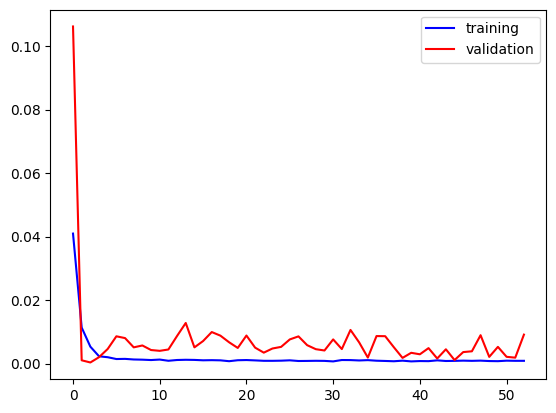

In [64]:
n_features = trainX.shape[2]

multi_model = Sequential()

# Adding the LSTM layer and dropout regularizaiton
multi_model.add(LSTM(100, return_sequences = True, input_shape=(n_steps_in, n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

# Adding output layer
multi_model.add(Dense(n_steps_out))

multi_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_squared_error')

earlystop = EarlyStopping(monitor = 'val_loss', patience =50,
                  mode = 'min',
                  verbose = 0)

fit = multi_model.fit(trainX,
          trainy, validation_data = (testX, testy),
          epochs = 500, verbose=0, callbacks = [earlystop])


# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

**Note**: The model was early stopped close to the 170th epoch.

### Feature Importance

There are a few ways to quantify and identify feature importance that influenced the recurrent neural network. Some of which include Pertubations, [Masking](https://stackoverflow.com/questions/44119207/is-there-any-way-to-get-variable-importance-with-keras)/[LIME](https://arxiv.org/abs/1606.05386), [Permutation Importance](https://www.kaggle.com/cdeotte/lstm-feature-importance)  and [SHAP](https://christophm.github.io/interpretable-ml-book/shap.html) (however, this led to many compatibility issues with tensorflow 2.7.0 on my end).

Here, we will be using pertubation effect which is quite similar to Masking and LIME. The idea here involves introducing noise/perturbing each variable with a random normal distribution then caclulate the difference between the perturbed predicted y and original predicted y.

**References**<br>
More information on pertubation on Neural Networks available [here](https://towardsdatascience.com/perturbation-theory-in-deep-neural-network-dnn-training-adb4c20cab1b) and [here](https://stats.stackexchange.com/questions/191855/variable-importance-in-rnn-or-lstm).

In [65]:
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218)
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(8):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')

feature_importance(multi_model,trainX)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Variable 1, Perturbation Effect: 0.048
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Variable 2, Perturbation Effect: 0.013
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Variable 3, Perturbation Effect: 0.044
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Variable 4, Perturbation Effect: 0.037
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Variable 5, Perturbation Effect: 0.079
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Variable 6, Perturbation Effect: 0.013
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Variable 7, Perturbation Effect: 0.014
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Variable 8, Perturbation Effect: 0.012


With the perturbation effect results, we could say that the important features for forecasting Core CPI in this model/dataset is past **Core CPI**, **Personal Consumption Expenditure**, and **M2**. Personal Consumption is one of the most important feature and this is obvious because PCE is also an important metric in determining inflation thus it should be closely correlated with Core CPI.


### Predictions on Test Set

After prediction, we need to invert the min-max normalization. To do so, we reshape the data back to the original form before the normalization.
- Reshape the testX and concatenate with the y-hat (prediction) at the correct positions
- Reshape the testX and concatenate with the actual y at the correct positions

To match the order of the original dataframe, we concatenate in the order of unemployment_rate, m2, pce, dspic, ffr, psr and cpi.

In [66]:
testPredict = multi_model.predict(testX)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [67]:
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))

In [68]:
# Invert scaling for Predicted
testY_hat = np.concatenate((testX[:, 1:8], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,7]

# Invert scaling for Actual
testY_actual = np.concatenate((testX[:,1:8], testy), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,7]

### Evaluating the multivariate LSTM

Similar to the previous models, we will use the same metrics: MSE and Mean Model Error.

In [69]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 147.371
Mean Model Error:  -12.058797428290069


<Axes: title={'center': 'Actual'}, xlabel='DATE'>

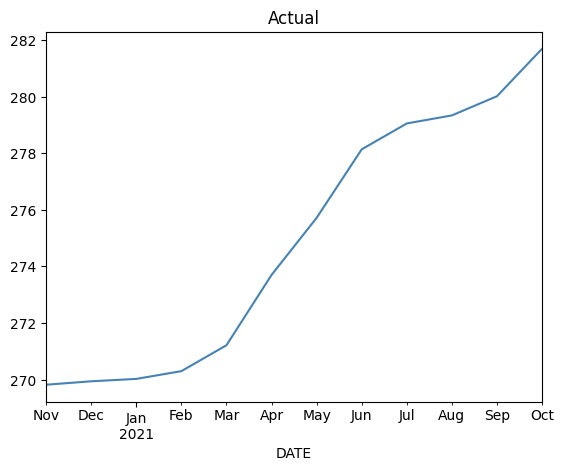

<Axes: title={'center': 'Forecasted'}>

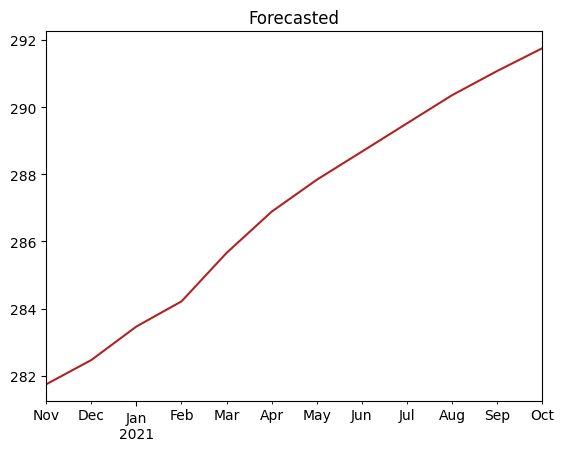

In [70]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(testY_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

As compared to the univariate LSTM, the model had a bad start in January was unable to 'approximate' the actual shape of the Core CPI in 2020.

### Forecast for November 2021

In [71]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)

# Manually inverse Min-max normalization
max_cpi = df_cpi['ccpi'].max()
min_cpi = df_cpi['ccpi'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast)

pct_chg = ((forecast - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
The Core CPI value for the month Nov 2021 predicted by LSTM is  281.6879562520904
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.4
